In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")
jHighSpeeds <- c("都市間高速", "都市高速", "有料道路")

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'RoadType', 'flag')
isValidColumn <- function(x) ! x %in% invalids

In [6]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.0133)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        } else {
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [7]:
correctVsPredict <- function(test, predictedFlags, verbose=FALSE) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
        
    if (verbose) {
        printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
        printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)  
    }    
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [8]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [9]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Reds

In [10]:
df3 <- read.csv("../data/middle/sp3.csv", stringsAsFactors=FALSE)

In [11]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [12]:
allFeatures <- c(colnames(df3))

In [13]:
roadTypes <- unique(df3$RoadType)

In [14]:
for (i in roadTypes) {
    printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
    dfx <- df3[df3$RoadType == i, ]
    expr <- createFormula(invalids, allFeatures)
    result <- CV(dfx, expr, verbose=FALSE)
    printRedRatios(dfx)
    printf("Red: Mean correct/predict = %f\n", result[2])
    printf("Blue: Mean correct/predict = %f\n", result[3])
    printf("CV value: %f", result[1])
    printf("\n\n")
}

RoadType: 7 (その他)
Red/All = 25/27 = 0.925926
1 - Red/All = 2/27 = 0.074074
Red: Mean correct/predict = 0.933333
Blue: Mean correct/predict = NaN
CV value: 0.066667

RoadType: 6 (一般道1、一般道2、一般道3)
Red/All = 90/189 = 0.476190
1 - Red/All = 99/189 = 0.523810
Red: Mean correct/predict = 0.623608
Blue: Mean correct/predict = 0.629235
CV value: 0.380994

RoadType: 4 (県道)
Red/All = 36/71 = 0.507042
1 - Red/All = 35/71 = 0.492958
Red: Mean correct/predict = 0.575000
Blue: Mean correct/predict = 0.541667
CV value: 0.454762

RoadType: 5 (主要地方道)
Red/All = 154/303 = 0.508251
1 - Red/All = 149/303 = 0.491749
Red: Mean correct/predict = 0.555743
Blue: Mean correct/predict = 0.561535
CV value: 0.438280

RoadType: 3 (国道)
Red/All = 202/324 = 0.623457
1 - Red/All = 122/324 = 0.376543
Red: Mean correct/predict = 0.657517
Blue: Mean correct/predict = 0.435706
CV value: 0.425758

RoadType: 0 (都市間高速)
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
Red: Mean correct/predict = 0.575476
Blue: Mean corr

In [15]:
fit3 <- rpart(expr, data=df3, method="class")

In [16]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01893096

In [17]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AheadDistance   AverageVelocity CurveAverage    DistManBicycle 
 [5] LaneCount       Pitch           RiskFactor      Speed          
 [9] SteeringAngle   TimeHeadway     TimeToCollision

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.037862      0   1.00000 1.00000 0.035602
2 0.035635      3   0.88641 0.99555 0.035582
3 0.026726      4   0.85078 0.96214 0.035418
4 0.024499      6   0.79733 0.93987 0.035292
5 0.018931      7   0.77283 0.92428 0.035195
6 0.013363      9   0.73497 0.93541 0.035265
7 0.011136     10   0.72160 0.95323 0.035369
8 0.010000     17   0.63697 0.94209 0.035305


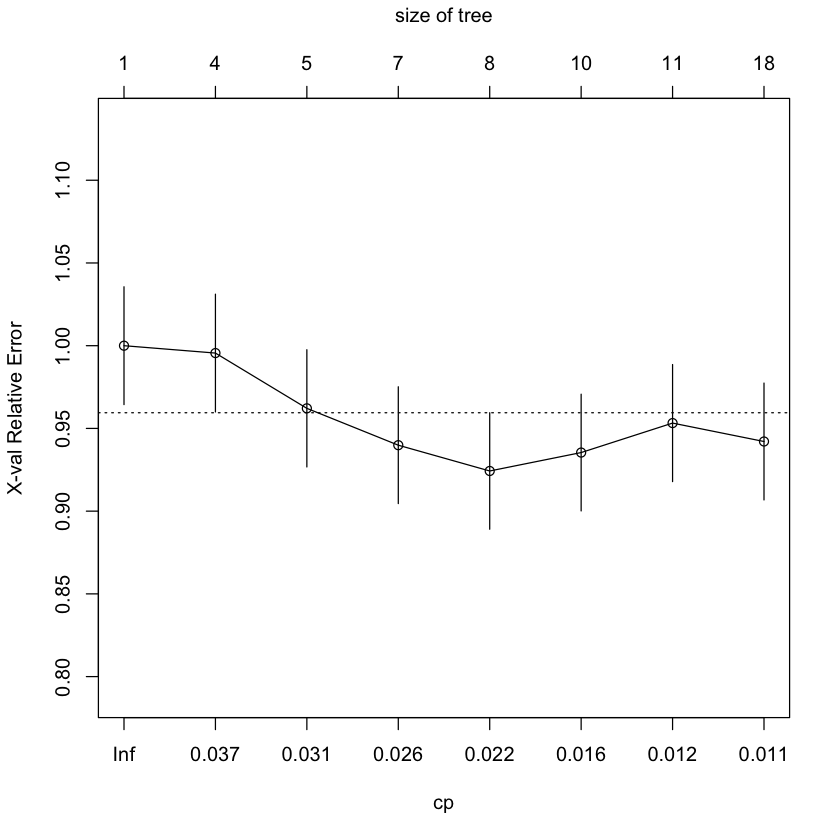

In [18]:
plotcp(fit3)

In [19]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.03786192      0 1.0000000 1.0000000 0.03560167
2 0.03563474      3 0.8864143 0.9955457 0.03558214
3 0.02672606      4 0.8507795 0.9621381 0.03541821
4 0.02449889      6 0.7973274 0.9398664 0.03529164
5 0.01893096      7 0.7728285 0.9242762 0.03519473
6 0.01336303      9 0.7349666 0.9354120 0.03526465
7 0.01113586     10 0.7216036 0.9532294 0.03536925
8 0.01000000     17 0.6369710 0.9420935 0.03530493

Variable importance
            Speed   AverageVelocity   TimeToCollision     AheadDistance 
               13                 9                 9                 8 
      TimeHeadway        RiskFactor     SteeringAngle      CurveAverage 
                8                 7                 7                 6 
            Curve          Curve100            Engine          Curve150 
                5                 4                 4                 4 
            